In [128]:
import sklearn as sk
from sklearn import linear_model
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels as stm

In [129]:
X = pd.read_csv('data/preprocessing/X.csv')
y = pd.read_csv('data/preprocessing/y.csv')

In [130]:
X.columns

Index(['educ_center',
       'harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)',
       'harass5_No', 'harass5_Yes', 'polviews_Conservative',
       'polviews_Extremely_liberal', 'polviews_Extrmly_conservative',
       'polviews_Liberal', 'polviews_Moderate',
       'polviews_Slghtly_conservative', 'polviews_Slightly_liberal',
       'advfront_Agree', 'advfront_Disagree', 'advfront_Dont_know',
       'advfront_Strongly_agree', 'advfront_Strongly_disagree', 'snapchat_No',
       'snapchat_Yes', 'instagrm_No', 'instagrm_Yes', 'wrkstat_Keeping_house',
       'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School',
       'wrkstat_Temp_not_working', 'wrkstat_Unempl,_laid_off',
       'wrkstat_Working_fulltime', 'wrkstat_Working_parttime'],
      dtype='object')

In [131]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1649 entries, 0 to 1648
Data columns (total 28 columns):
 #   Column                                                           Non-Null Count  Dtype  
---  ------                                                           --------------  -----  
 0   educ_center                                                      1649 non-null   float64
 1   harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)  1649 non-null   int64  
 2   harass5_No                                                       1649 non-null   int64  
 3   harass5_Yes                                                      1649 non-null   int64  
 4   polviews_Conservative                                            1649 non-null   int64  
 5   polviews_Extremely_liberal                                       1649 non-null   int64  
 6   polviews_Extrmly_conservative                                    1649 non-null   int64  
 7   polviews_Liberal                          

In [132]:
size = y.shape[0]
mu = 0
sigma = 1e-3
noise = np.random.normal(mu,sigma,size)

In [133]:
y['noise'] = y['email_time_center'] + sigma

In [134]:
y[y['noise'] == 0]

,email_time_center,noise


array([[<Axes: title={'center': 'email_time_center'}>,
        <Axes: title={'center': 'noise'}>]], dtype=object)

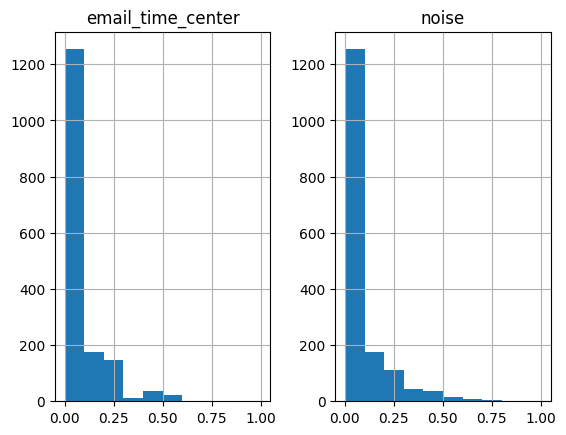

In [135]:
y.hist()

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y['noise'], test_size=0.2, random_state=0)

In [137]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1319, 28)
(330, 28)
(1319,)
(330,)


In [138]:
def print_metrics(y_test, y_pred):
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, y_pred)
  
  print(f'metrics, mse: {mse}, rmse: {rmse}, r2: {r2}')

In [139]:
link_function = stm.genmod.families.links.Log()
gamma_model = stm.api.GLM(y_train, X_train, family=stm.api.families.Gamma(link=link_function))
# gamma_model = stm.api.GLM(y_train, X_train, family=stm.api.families.Gamma())
gamma_results = gamma_model.fit(method='lbfgs')
gamma_results.summary()

/home/linhnm/msc_code/social-stat-final-term/venv/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1292
Model Family:                   Gamma   Df Model:                           26
Link Function:                    Log   Scale:                          2.7225
Method:                         lbfgs   Log-Likelihood:                 2446.1
Date:                Mon, 14 Aug 2023   Deviance:                       2766.4
Time:                        21:40:58   Pearson chi2:                 3.52e+03
No. Iterations:                    76   Pseudo R-squ. (CS):             0.1155
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
educ_center                                                         1.7498      0.336      5.207      0.000       1.091       2.409
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)     0.5757      1.705      0.338      0.736      -2.767       3.918
harass5_No                                                          1.6434      1.659      0.991      0.322      -1.608       4.895
harass5_Yes                                                         2.1376      1.672      1.279      0.201      -1.139       5.414
polviews_Conservative                                              -0.3103      0.287     -1.081      0.280      -0.873       0.252
polviews_Extremely_liberal                                         -0.3731      0.339     -1.100      0.272      -1.038       0.292
polviews_Extrmly_conservative                                      -0.8881      0.349     -2.546      0.011      -1.572      -0.205
polviews_Liberal                                                   -0.4096      0.292     -1.402      0.161      -0.982       0.163
polviews_Moderate                                                  -0.2551      0.267     -0.956      0.339      -0.778       0.268
polviews_Slghtly_conservative                                      -0.4439      0.287     -1.550      0.121      -1.005       0.118
polviews_Slightly_liberal                                          -0.2263      0.294     -0.771      0.441      -0.802       0.349
advfront_Agree                                                      1.8392      1.659      1.109      0.268      -1.412       5.090
advfront_Disagree                                                   2.0708      1.664      1.244      0.213      -1.191       5.333
advfront_Dont_know                                                  1.3055      1.719      0.760      0.448      -2.063       4.674
advfront_Strongly_agree                                             1.8806      1.660      1.133      0.257      -1.373       5.134
advfront_Strongly_disagree                                          2.8589      1.790      1.597      0.110      -0.650       6.368
snapchat_No                                                        -0.0356   5.93e+06     -6e-09      1.000   -1.16e+07    1.16e+07
snapchat_Yes                                                        0.2510   5.93e+06   4.23e-08      1.000   -1.16e+07    1.16e+07
instagrm_No                                                         0.1412   5.93e+06   2.38e-08      1.000   -1.16e+07    1.16e+07
instagrm_Yes                                                        0.0742   5.93e+06   1.25e-08      1.000   -1.16e+07    1.16e+07
wrkstat_Keeping_house                          

In [140]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1292
Model Family:                   Gamma   Df Model:                           26
Link Function:                    Log   Scale:                          2.7225
Method:                         lbfgs   Log-Likelihood:                 2446.1
Date:                Mon, 14 Aug 2023   Deviance:                       2766.4
Time:                        21:40:58   Pearson chi2:                 3.52e+03
No. Iterations:                    76   Pseudo R-squ. (CS):             0.1155
Covariance Type:            nonrobust                                         
===================================================================================================================================
                                                                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------
educ_center                                                         1.7498      0.336      5.207      0.000       1.091       2.409
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)     0.5757      1.705      0.338      0.736      -2.767       3.918
harass5_No                                                          1.6434      1.659      0.991      0.322      -1.608       4.895
harass5_Yes                                                         2.1376      1.672      1.279      0.201      -1.139       5.414
polviews_Conservative                                              -0.3103      0.287     -1.081      0.280      -0.873       0.252
polviews_Extremely_liberal                                         -0.3731      0.339     -1.100      0.272      -1.038       0.292
polviews_Extrmly_conservative                                      -0.8881      0.349     -2.546      0.011      -1.572      -0.205
polviews_Liberal                                                   -0.4096      0.292     -1.402      0.161      -0.982       0.163
polviews_Moderate                                                  -0.2551      0.267     -0.956      0.339      -0.778       0.268
polviews_Slghtly_conservative                                      -0.4439      0.287     -1.550      0.121      -1.005       0.118
polviews_Slightly_liberal                                          -0.2263      0.294     -0.771      0.441      -0.802       0.349
advfront_Agree                                                      1.8392      1.659      1.109      0.268      -1.412       5.090
advfront_Disagree                                                   2.0708      1.664      1.244      0.213      -1.191       5.333
advfront_Dont_know                                                  1.3055      1.719      0.760      0.448      -2.063       4.674
advfront_Strongly_agree                                             1.8806      1.660      1.133      0.257      -1.373       5.134
advfront_Strongly_disagree                                          2.8589      1.790      1.597      0.110      -0.650       6.368
snapchat_No                                                        -0.0356   5.93e+06     -6e-09      1.000   -1.16e+07    1.16e+07
snapchat_Yes                                                        0.2510   5.93e+06   4.23e-08      1.000   -1.16e+07    1.16e+07
instagrm_No                                                         0.1412   5.93e+06   2.38e-08      1.000   -1.16e+07    1.16e+07
instagrm_Yes                                                        0.0742   5.93e+06   1.25e-08      1.000   -1.16e+07    1.16e+07
wrkstat_Keeping_house                          

In [141]:
y_pred = gamma_results.predict(X_test)
print_metrics(y_test, y_pred)

metrics, mse: 0.00901724897484081, rmse: 0.094959196367918, r2: 0.08931380081135276


In [154]:
choices = ['educ_center', 'wrkstat_Keeping_house', 'wrkstat_Other', 'wrkstat_Retired', 'wrkstat_School', 'wrkstat_Temp_not_working', 'wrkstat_Unempl,_laid_off', 'wrkstat_Working_fulltime', 'wrkstat_Working_parttime']
# choices = ['educ_center', 'polviews_Extrmly conservative']
X_train_choice = X_train[X_train.columns.intersection(choices)]
X_test_choice = X_test[X_test.columns.intersection(choices)]

In [155]:
X_train_choice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1319 entries, 887 to 684
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   educ_center               1319 non-null   float64
 1   wrkstat_Keeping_house     1319 non-null   int64  
 2   wrkstat_Other             1319 non-null   int64  
 3   wrkstat_Retired           1319 non-null   int64  
 4   wrkstat_School            1319 non-null   int64  
 5   wrkstat_Temp_not_working  1319 non-null   int64  
 6   wrkstat_Unempl,_laid_off  1319 non-null   int64  
 7   wrkstat_Working_fulltime  1319 non-null   int64  
 8   wrkstat_Working_parttime  1319 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 103.0 KB


In [156]:
link_function = stm.genmod.families.links.Log()
gm_model = stm.api.GLM(y_train, X_train_choice, family=stm.api.families.Gamma(link=link_function))
gm_res = gm_model.fit(method='lbfgs')
gm_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  noise   No. Observations:                 1319
Model:                            GLM   Df Residuals:                     1310
Model Family:                   Gamma   Df Model:                            8
Link Function:                    Log   Scale:                          3.1713
Method:                         lbfgs   Log-Likelihood:                 2367.1
Date:                Mon, 14 Aug 2023   Deviance:                       2861.4
Time:                        21:44:30   Pearson chi2:                 4.15e+03
No. Iterations:                    16   Pseudo R-squ. (CS):            0.07930
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
educ_center                  1.4805      0.331      4.476      0.000       0.832       2.129
wrkstat_Keeping_house       -4.5508      0.267    -17.043      0.000      -5.074      -4.027
wrkstat_Other               -3.9870      0.418     -9.535      0.000      -4.807      -3.167
wrkstat_Retired             -4.2569      0.241    -17.699      0.000      -4.728      -3.786
wrkstat_School              -4.4415      0.356    -12.479      0.000      -5.139      -3.744
wrkstat_Temp_not_working    -3.8865      0.416     -9.342      0.000      -4.702      -3.071
wrkstat_Unempl,_laid_off    -3.7014      0.319    -11.608      0.000      -4.326      -3.076
wrkstat_Working_fulltime    -3.3562      0.241    -13.943      0.000      -3.828      -2.884
wrkstat_Working_parttime    -3.9947      0.258    -15.489      0.000      -4.500      -3.489
============================================================================================
"""

In [157]:
y_pred = gm_res.predict(X_test_choice)

In [158]:
print(y_pred.shape)

(330,)


In [159]:
print_metrics(y_test, y_pred)

metrics, mse: 0.008810617366608622, rmse: 0.09386488889147326, r2: 0.11018231120274202
